<a href="https://colab.research.google.com/github/Padmashree02/Object_Detection_YOLO_V8/blob/main/Main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imported required libraries

import os
import numpy as np
import cv2
import sys
import time
import requests
import zipfile
from os import path
import matplotlib.pyplot as plt
%matplotlib inline

!pip install ultralytics
from ultralytics import YOLO
from ultralytics.utils.checks import check_yaml

In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install ultralytics==8.2.80 -q
!pip install opencv-python==4.10.0.84 -q
!pip install matplotlib -q
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.80 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.2/112.6 GB disk)


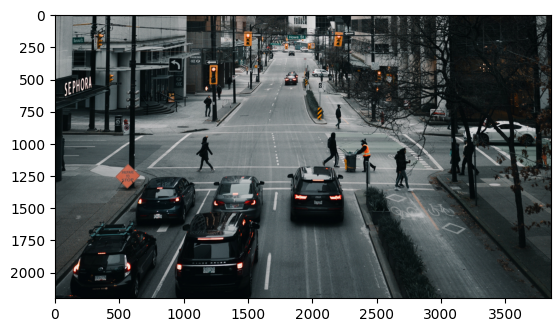

In [3]:
#Load the image for the input data purpose
image=cv2.imread('/content/street.jpg')

#Display the image by swaping BGR to RGB format
plt.imshow(image[:,:,::-1])

In [4]:
#load the Yolo V8
yolov8s = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 268MB/s]


In [5]:
#exporting the model from .pt to .onnx format
yolov8s.export(format='onnx')

Ultralytics YOLOv8.2.80 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs

PyTorch: starting from 'yolov8s.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (21.5 MB)

ONNX: starting export with onnx 1.18.0 opset 19...
ONNX: export success ✅ 1.2s, saved as 'yolov8s.onnx' (42.8 MB)

Export complete (4.5s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8s.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8s.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov8s.onnx'

In [6]:
#Load and extract the classes from class file (coco) => 80 classes
class_file = '/content/coco.names'

with open (class_file,'rt') as f:
  classes=f.read().rstrip('\n').split('\n')
  print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [7]:
#Extracting all output layers from Yolo V8 model
def getOutputsNames(model):
    layersNames = model.getLayerNames()
    for i in model.getUnconnectedOutLayers():
      layer=layersNames[i - 1]
    return layer

In [8]:
#Define the parameters for the YOLO V8 model

#Thresholds
confidence_threshold=0.5  #removes those bounding boxes which has less confidence in detecting
nms_threshold=0.4         #removes those bounding boxes that are overlapped

#Image's shape based on YOLO V8 model
img_w=640
img_h=640

In [9]:
#Define the detection function (detects the object)

def detection(img,model):
  #Default values
  mean=(0,0,0)

  #convert the image into network understanding format (blob)
  blob=cv2.dnn.blobFromImage(img,1/255,(img_w,img_w),mean,1,crop=False)

  #Set the input data to the DenseNet model
  model.setInput(blob)

  #Get output layers of Yolo V8 model
  output_layers=model.getUnconnectedOutLayersNames()

  #Pass the image directly to the output layer
  detected_obj=model.forward(output_layers)

  return detected_obj

In [10]:
#Define the function that display the detected class on each detected object

def draw_text(im, text, x, y, id):

    #Default Text values
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.5
    thickness = 4

    #Display every detected object of different classes with different colours
    color=COLORS[id]

    #Get text size
    textSize = cv2.getTextSize(text, fontface, font_scale, thickness)  #returns in tuple
    dim = textSize[0]        # width,height
    baseline = textSize[1]

    #Use text size to create a black rectangle. (top left and bottom right)
    cv2.rectangle(im, (x, y), (x + dim[0], y + dim[1] + baseline), color, cv2.FILLED);

    #Display text inside the rectangle
    cv2.putText(im, text, (x, y + dim[1]), fontface, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)

In [11]:
#Object detection process

#to display each class with different colors
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

def draw_object(img,objects_detected):

  #operation - transpose and squeeze to match it with expected shape (because to change shape format from (84,8400) to (8400,84))
  outputs=np.transpose(np.squeeze(objects_detected[0]))

  rows=outputs.shape[0]

  valid_detections=0
  boxes=[]
  scores=[]
  class_ids=[]

  #define the height and width wrt image's dimension
  img_height=img.shape[0]
  img_width=img.shape[1]

  #computing the scaling factors for the bounding box coordinates
  x_factor=img_width/img_w
  y_factor=img_height/img_h

  #process each detection
  for i in range(rows):
    #Extract all scores detected wrt each class
    classes_score=outputs[i,4:]

    #Extract the classID
    maxscore_id=np.argmax(classes_score)

    #Confidence score
    maxscore=np.amax(classes_score)

    #Checking whether the the object has been detected good or bad
    if maxscore>confidence_threshold:

      #convert the normalized coordinates to origional coordinates wrt defined image's shape
      x,y,w,h=outputs[i,0],outputs[i,1],outputs[i,2],outputs[i,3]

      left=int((x-w/2)*x_factor)
      top=int((y-h/2)*y_factor)
      width=int(w*x_factor)
      height=int(h*y_factor)

      #Append all values in respective list
      scores.append(maxscore)
      class_ids.append(maxscore_id)
      boxes.append([left,top,width,height])

  #Perform Non Maximum Suppression on each detected object
  indices=cv2.dnn.NMSBoxes(boxes,scores,confidence_threshold,nms_threshold)
  for i in indices:

    #Count the valid detections
    valid_detections=valid_detections+1

    #Extract each element from bounding box list
    box=boxes[i]
    left=box[0]
    top=box[1]
    width=box[2]
    height=box[3]

    #Draw the bounding box to display the detected object
    cv2.rectangle(img,(left,top),(left+width,top+height),COLORS[class_ids[i]],5)

    #Display the class name
    label=f"{classes[class_ids[i]]}: {scores[i]:.2f}"
    draw_text(img,label,left,top,class_ids[i])

  return img,valid_detections

In [12]:
#Compute the inference time (scr :- video or image)
def put_efficiency(inference_time, is_video=False):
    if is_video:
        # Calculate FPS based on inference time
        fps = 1 / inference_time
        label = 'FPS: %.2f' % fps
    else:
        # Convert the timing information to milliseconds and create a label string
        label = 'Inference Time: %.2f ms' % (inference_time * 1000.0)
    return label

Inference Time: 860.15 ms
Number of good object detections = 13


True

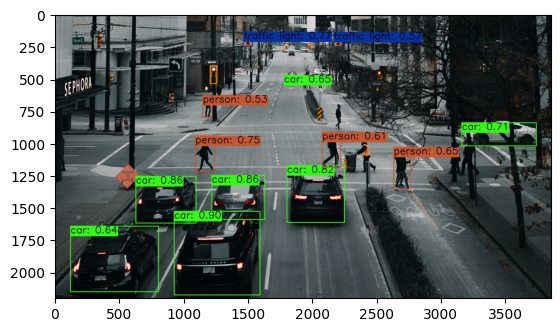

In [13]:
#Load the Yolov8 models (Yolov8)
model_file='/content/yolov8s.onnx'

#read the model or neural network
model=cv2.dnn.readNetFromONNX(model_file)

#Calling all the defined fucntions

#Start the timer
start_time = time.time()

#Detects the objects on the input image
objects_detected=detection(image,model)

#Measures the inference time of the model
inference_time = time.time() - start_time

#Annotate the detected objects
img_result,valid_detections=draw_object(image.copy(),objects_detected)

#Displays how long does the model executes Object detection on the image
label=put_efficiency(inference_time, is_video=False)
print(label)

#Display the face detection result of the image
plt.imshow(img_result[:,:,::-1])
print("Number of good object detections =",valid_detections)

#Save the output image
cv2.imwrite("Object_detection_YOLOV8.jpg",img_result)